In [15]:
import os
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import stdev, mean
import seaborn as sns
import SeabornFig2Grid as sfg
import matplotlib.gridspec as gridspec
import Function_4_Plot_xy_scatter_grid as f4
%load_ext autoreload
%autoreload 2


def get_hypot(dx,dy):
    hypot = abs(math.sqrt(dx**2 + dy**2))
    return hypot

def plot_nice(df:pd.DataFrame):
    # Clean start
    plt.close('all')

    # Create one figure and one axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Group by 'Direction' and plot each with error bars
    for direction, group in df.groupby('Direction'):
        group = group.sort_values('Time_in_min')
        ax.errorbar(
            group['Time_in_min'],
            group['Mean_px_drift'],
            yerr=group['SE_px_drift'],
            label=direction,
            capsize=3,
            marker='o',
            linestyle='-'
        )

    # Labeling and formatting
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Mean Pixel Drift')
    ax.set_title('Drift over Time by Direction')
    ax.legend(title='Direction')
    ax.grid(True)

    # Show one final plot
    fig.tight_layout()
    plt.show()

    plt.xlabel('Time (min)')
    plt.ylabel('Mean Pixel Drift')
    plt.title('Drift over Time by Direction')
    plt.legend(title='Direction')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def bplot(df:pd.DataFrame, x='Time_in_min'):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=x, y='px_drift')

    plt.xlabel('Time (min)')
    plt.ylabel('Pixel Drift')
    plt.title('Distribution of Pixel Drift by Time')
    plt.xticks(rotation=45)  # Optional: Rotate if too crowded
    plt.tight_layout()
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Create a table incorporating all cross correlation data tables in subfolders
filename = 'Coord_table_cv2_cross_correlation.csv'

all_data = pd.DataFrame()

# Assign directory
directory = input('Enter parent directory: ')

# Iterate over files in directory
for path, folders, files in os.walk(directory):
    for folder_name in folders:
        if filename in os.listdir(f'{path}/{folder_name}'):
            print(f'Content of {folder_name}')
            with open(f'{path}/{folder_name}/{filename}') as f:
                px_drift = []
                data = pd.read_csv(f)
                print(data)

                for i in range(len(data['Crosscor_tx_px'])):
                    px_drift.append(get_hypot(data['Crosscor_tx_px'][i],data['Crosscor_ty_px'][i]))
                data['px_drift'] = px_drift
                
                all_data = pd.concat([all_data,data]).reset_index(drop=True)
useful_data = all_data[['Direction','Time_in_min','px_drift']].fillna(0)
useful_data.sort_values('Direction')

Content of Align_cross_corr
    Unnamed: 0                                         Image_path  \
0            0  /media/marcus1/large_chungus/data_collection/1...   
1            1  /media/marcus1/large_chungus/data_collection/1...   
2            2  /media/marcus1/large_chungus/data_collection/1...   
3            3  /media/marcus1/large_chungus/data_collection/1...   
4            4  /media/marcus1/large_chungus/data_collection/1...   
..         ...                                                ...   
94           6  /media/marcus1/large_chungus/data_collection/1...   
95           7  /media/marcus1/large_chungus/data_collection/1...   
96           8  /media/marcus1/large_chungus/data_collection/1...   
97           9  /media/marcus1/large_chungus/data_collection/1...   
98          10  /media/marcus1/large_chungus/data_collection/1...   

                  Image_name         Protocol  ID  Slice_number  \
0   000_x-4500y-4500z0_t0_m0  long_term_drift   0             1   
1   001_x

Direction  Time_in_min  px_drift
2791  X_negative            8  0.014142
510   X_negative            4  0.036056
511   X_negative            5  0.078102
512   X_negative            6  0.050000
513   X_negative            7  0.041231
...          ...          ...       ...
3418        Zero            8  0.183848
3417        Zero            7  0.114018
3416        Zero            6  0.200000
739         Zero            2  0.041231
2326        Zero            5  0.278029

[4653 rows x 3 columns]

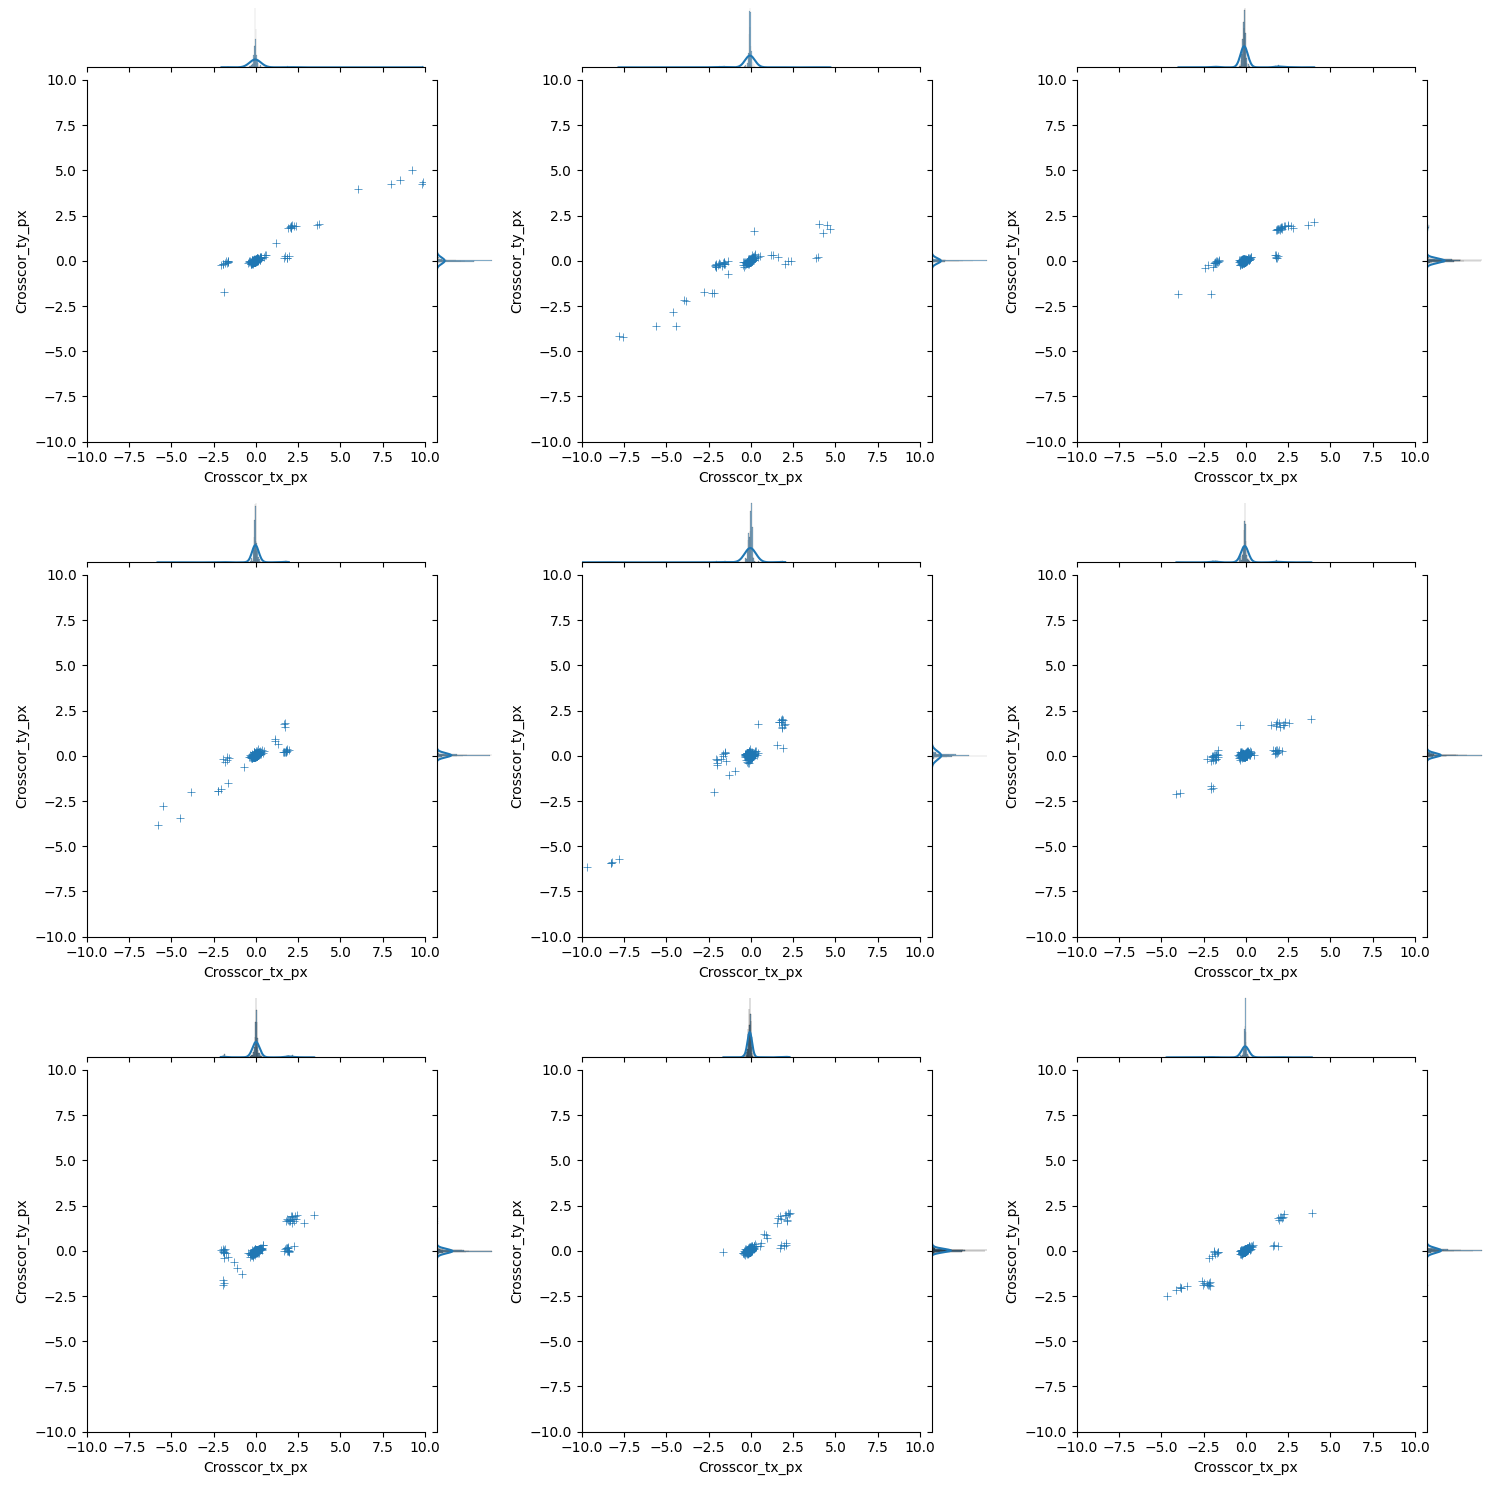

In [18]:
direction_positions = {
    'X_negative_Y_positive': (0, 0),
    'Y_positive':            (0, 1),
    'X_positive_Y_positive': (0, 2),
    'X_negative':            (1, 0),
    'Zero':                  (1, 1),
    'X_positive':            (1, 2),
    'X_negative_Y_negative': (2, 0),
    'Y_negative':            (2, 1),
    'X_positive_Y_negative': (2, 2),
    }

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3,3)

groups = all_data.groupby('Direction')
q = 0

for direction, (i,j) in direction_positions.items():
    group = groups.get_group(direction)
    figure = sns.jointplot(data=group,x='Crosscor_tx_px',y='Crosscor_ty_px',dropna=True,marker='+',space=0,marginal_kws=dict(kde=True))
    figure.ax_marg_x.set_xlim(-10,10)
    figure.ax_marg_y.set_ylim(-10,10)
    sfg.SeabornFig2Grid(figure, fig, gs[q])

    q += 1

gs.tight_layout(fig)


In [19]:
scale_factor = 1/5.025 #5.025px per 1um
# Adding and fixing data in the table
all_data['Crosscor_tx_microm'] = all_data['Crosscor_tx_px'] * scale_factor
all_data['Crosscor_ty_microm'] = all_data['Crosscor_ty_px'] * scale_factor
all_data['tot_drift_microm'] = all_data['px_drift'] * scale_factor
all_data.rename(columns={'Unnamed: 0': 'img_number'}, inplace=True)
#all_data.drop(columns='Unnamed: 0.1', inplace=True)
all_data['Date'] = all_data['Image_path'].str.extract(r'(\d{4}-\d{2}-\d{2})')
all_data['DateTime'] = all_data['Image_path'].str.extract(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})')

all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])

In [20]:
# Save the file
all_data.to_csv(f'{directory}/all_drift_data.csv',index=False)

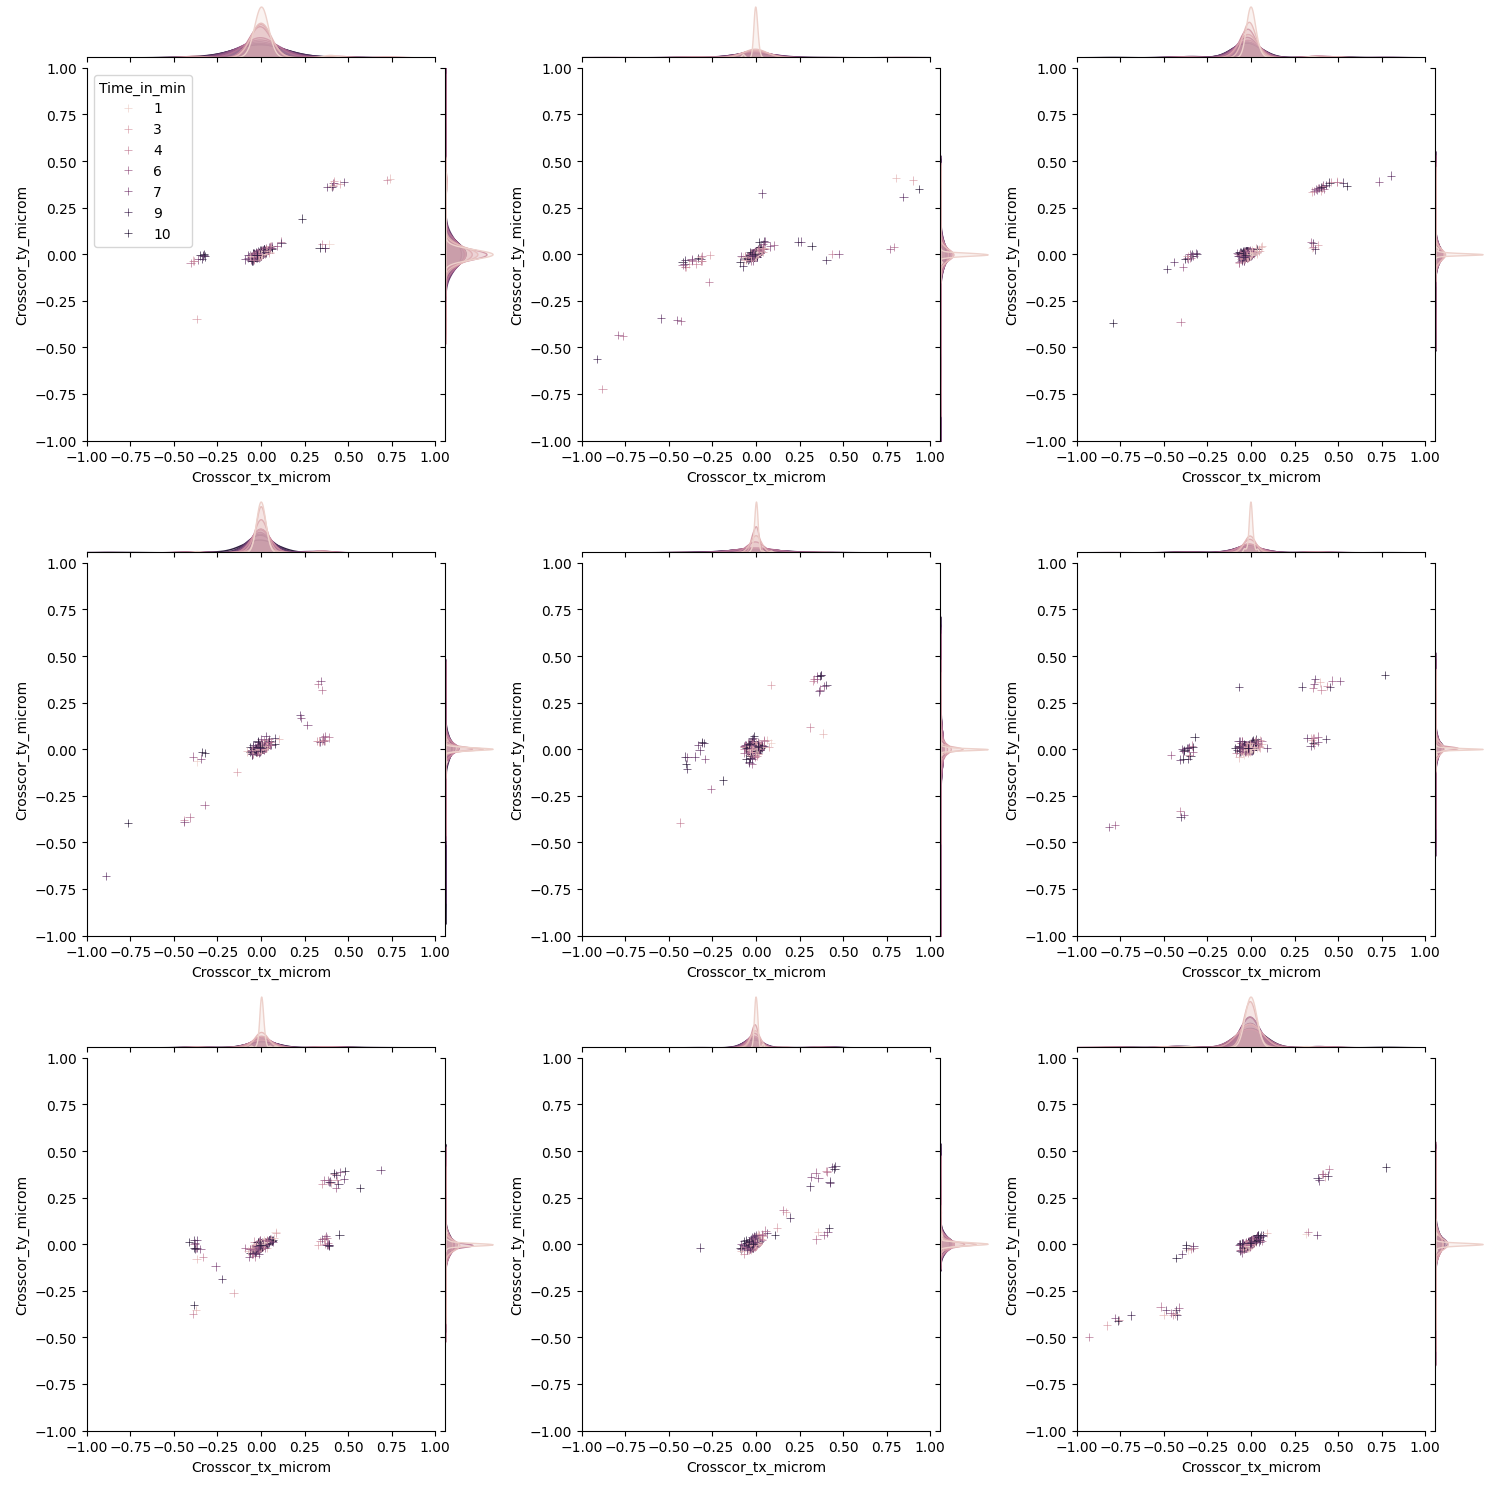

In [21]:
direction_positions = {
    'X_negative_Y_positive': (0, 0),
    'Y_positive':            (0, 1),
    'X_positive_Y_positive': (0, 2),
    'X_negative':            (1, 0),
    'Zero':                  (1, 1),
    'X_positive':            (1, 2),
    'X_negative_Y_negative': (2, 0),
    'Y_negative':            (2, 1),
    'X_positive_Y_negative': (2, 2),
    }

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3,3)

groups = all_data.groupby('Direction')
q = 0

for direction, (i,j) in direction_positions.items():
    if q ==0:
        legend = True
    else:
        legend = False
    group = groups.get_group(direction)
    figure = sns.jointplot(data=group,x='Crosscor_tx_microm',y='Crosscor_ty_microm',dropna=True,marker='+',hue='Time_in_min',legend=legend)
    figure.ax_marg_x.set_xlim(-1,1)
    figure.ax_marg_y.set_ylim(-1,1)
    sfg.SeabornFig2Grid(figure, fig, gs[q])

    q += 1

gs.tight_layout(fig)


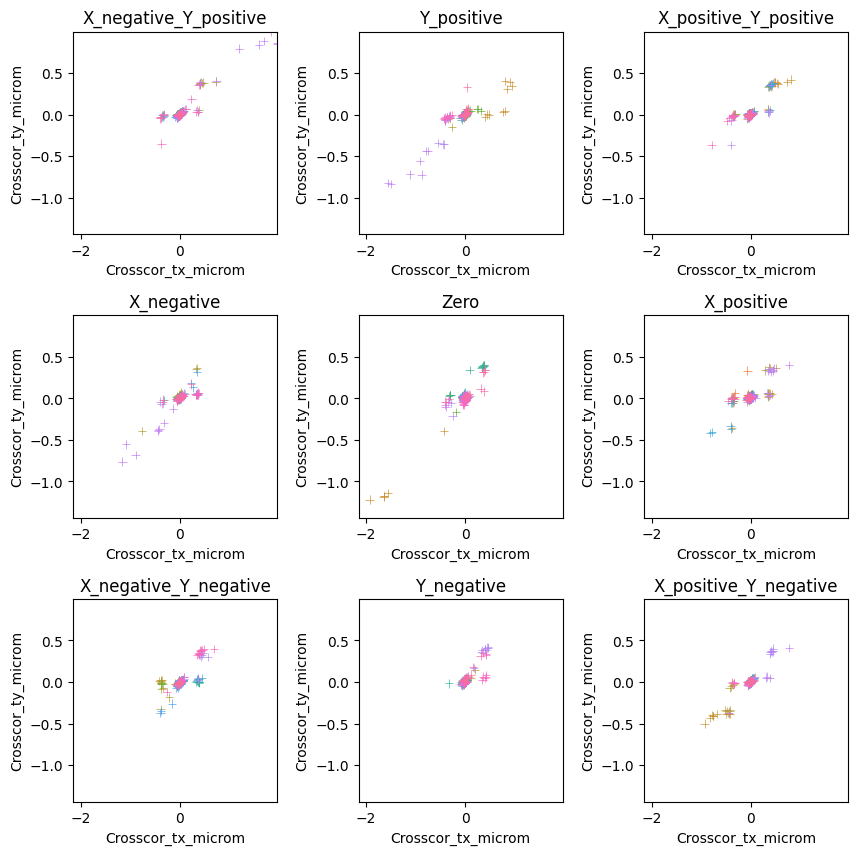

In [22]:
direction_positions = {
    'X_negative_Y_positive': (0, 0),
    'Y_positive':            (0, 1),
    'X_positive_Y_positive': (0, 2),
    'X_negative':            (1, 0),
    'Zero':                  (1, 1),
    'X_positive':            (1, 2),
    'X_negative_Y_negative': (2, 0),
    'Y_negative':            (2, 1),
    'X_positive_Y_negative': (2, 2),
    }

# Create the 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Group data by direction and plot KDEs
for direction, group in all_data.groupby('Direction'):
    if direction not in direction_positions:
        continue  # Skip unknown directions

    i, j = direction_positions[direction]
    ax = axes[i, j]
    sns.scatterplot(
        data=group,
        x='Crosscor_tx_microm', y='Crosscor_ty_microm',
        ax=ax,
        hue='DateTime',
        legend=False,
        marker='+'
    )
    ax.set_title(direction)
    ax.set_xlim(all_data['Crosscor_tx_microm'].min(), all_data['Crosscor_tx_microm'].max())
    ax.set_ylim(all_data['Crosscor_ty_microm'].min(), all_data['Crosscor_ty_microm'].max())



<Axes: xlabel='tot_drift_microm', ylabel='Count'>

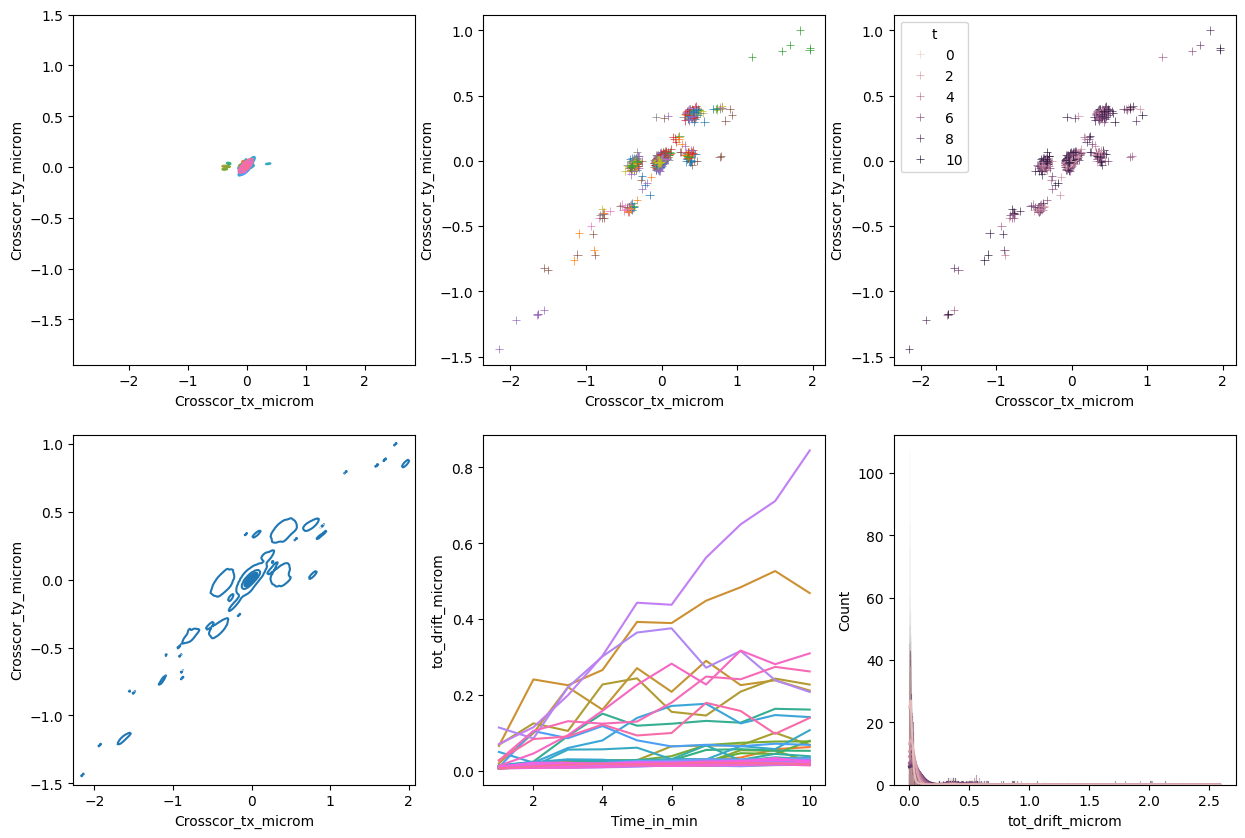

In [28]:
fig, axs = plt.subplots(2,3, figsize=(15,10))

sns.kdeplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',hue='DateTime',ax=axs[0,0],legend=False,thresh=0.01)
sns.scatterplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',hue='Direction',ax=axs[0,1],legend=False,marker='+')
sns.scatterplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',hue='t',ax=axs[0,2],marker='+')
sns.kdeplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',ax=axs[1,0],thresh=0.01)
sns.lineplot(data=all_data,x='Time_in_min',y='tot_drift_microm',hue='DateTime',ax=axs[1,1],legend=False,errorbar=None)
#sns.rugplot(data=all_data,y='tot_drift_microm',ax=axs[1,1])
sns.histplot(data=all_data,x='tot_drift_microm',discrete=False,kde=True,hue='Time_in_min',ax=axs[1,2],legend=False)



Text(0, 0.5, 'Drift (μm)')

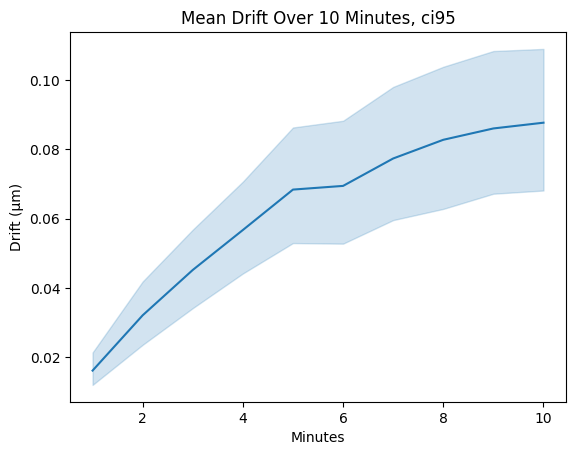

In [47]:
meanDriftPlot = sns.lineplot(data=all_data,x='Time_in_min',y='tot_drift_microm',legend=False,errorbar=("ci",95),estimator='mean')
meanDriftPlot.set_title("Mean Drift Over 10 Minutes, ci95")
meanDriftPlot.set_xlabel("Minutes")
meanDriftPlot.set_ylabel("Drift (μm)")

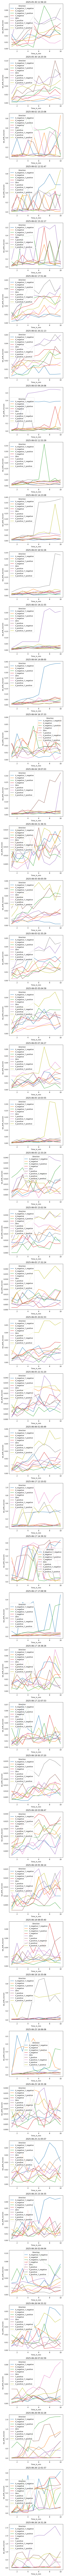

In [ ]:
#Generate a lineplot for um drift for each individual datetime... ((Slow))
groups = all_data.groupby('DateTime') 
fig, axs = plt.subplots(len(groups),1,figsize = (6,6.1*len(groups)))
for i, (key, group_df) in enumerate(groups):
    sns.lineplot(data=group_df,x='Time_in_min',y='tot_drift_microm',ax=axs[i],errorbar=None,hue='Direction').set(title=key)


In [26]:
groups

<Axes: xlabel='Crosscor_tx_microm', ylabel='Crosscor_ty_microm'>

<Figure size 1000x1000 with 0 Axes>

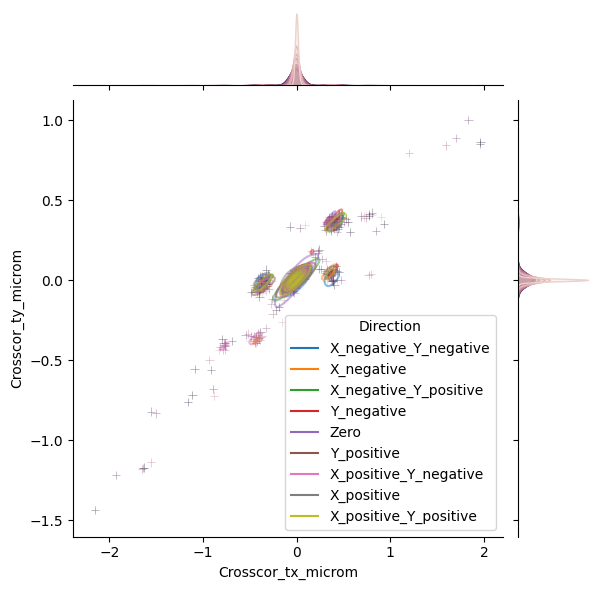

In [25]:
plt.figure(figsize=(10,10))
sns.jointplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',marker='+',alpha=0.5,hue='Time_in_min',dropna=True)
sns.kdeplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',alpha=0.5,color='r',hue='Direction')

(-0.9, 0.9)

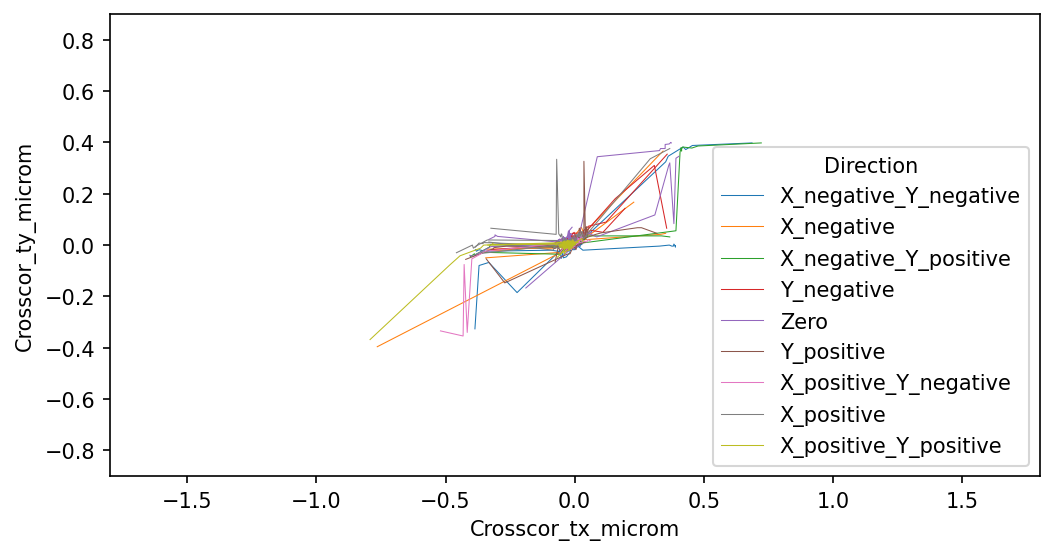

In [62]:
line = plt.figure(figsize=(8,4),dpi=150)
xlim = 1.8
ylim = 0.9

line = sns.lineplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',hue='Direction',units='DateTime',estimator=None,lw=0.5,legend=True)
#sns.kdeplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',fill=True,thresh=0.05)
line.set_xlim(left=-xlim,right=xlim)
line.set_ylim(bottom=-ylim,top=ylim)

(-0.9, 0.9)

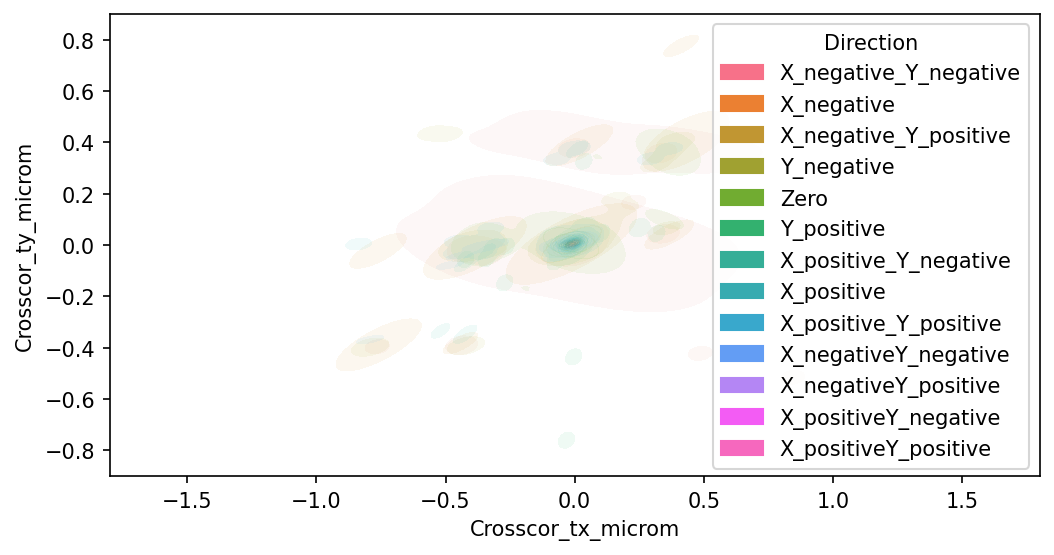

In [13]:
kd = plt.figure(figsize=(8,4),dpi=150)
xlim = 1.8
ylim = 0.9

kd = sns.kdeplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',hue='Direction',thresh=0.01,legend=True,fill=True,alpha=1/9)
#sns.kdeplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',fill=True,thresh=0.05)
kd.set_xlim(left=-xlim,right=xlim)
kd.set_ylim(bottom=-ylim,top=ylim)